In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# Kalman filter and smoother (linear case)
from pykalman import KalmanFilter

# data assimilation routines
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# IMPACT OF ERROR COVARIANCES

In this example, we show in a simple linear state-space model, the impact of badly scaled error covariances $Q$ and $R$. We generate true state following a AR(1) dynamical equation and we generate noisy observations.

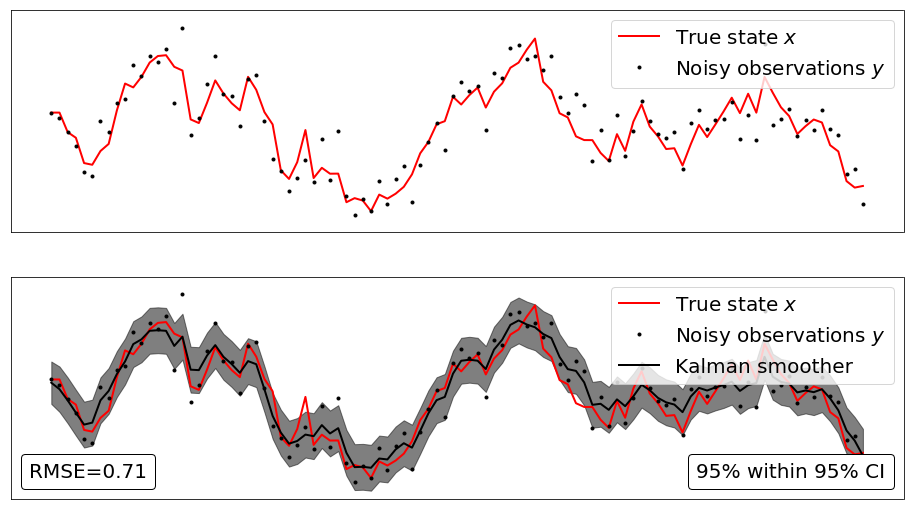

In [2]:
# random number generator
numpy.random.seed(9)

# generate true state and noisy observations
Nx=1
No=1
Q_true=eye(Nx)
R_true=eye(No)
T=100

# generate y and x
X_true=zeros(T)
Yo=zeros(T)
for t in range(T):
    if t>0:
        X_true[t]=0.95*X_true[t-1]+random.normal(0,Q_true)
        Yo[t]=X_true[t]+random.normal(0,R_true)

# apply Kalman smoother with good covariances
kf_true_Q_R = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = R_true)
Xs_true_Q_R, Ps_true_Q_R = kf_true_Q_R.smooth(Yo)      

# plot
figure()
subplot(2,1,1)
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
ylim(min(Yo)-1,max(Yo)+1)
xticks([]);yticks([])
legend([line1, line2], ['True state $x$', 'Noisy observations $y$'], prop={'size': 20})        
#title('True state $x$ (red) and noisy observations $y$ (dark)',fontsize=20)

ax0=subplot(2,1,2)
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_true_Q_R,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)),
                        squeeze(Xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
at=AnchoredText('RMSE='+str(round(RMSE(ravel(Xs_true_Q_R)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax0.add_artist(at)
at=AnchoredText('95% within 95% CI',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax0.add_artist(at)
xticks([]);yticks([])
legend([line1, line2, line3], ['True state $x$', 'Noisy observations $y$', 'Kalman smoother'], prop={'size': 20})  
#title('Smoothing with $Q=Q^t$ and $R=R^t$', fontsize=20)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp_x_y_AR1.png', bbox_inches='tight', pad_inches=0)

In [3]:
# apply Kalman smoother with bad covariances (underestimation)
kf_Q_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 0.1*Q_true, observation_covariance = R_true)
kf_R_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = 0.1*R_true)
kf_Q_R_underest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 0.1*Q_true, observation_covariance = 0.1*R_true)
Xs_Q_underest, Ps_Q_underest = kf_Q_underest.smooth(Yo)
Xs_R_underest, Ps_R_underest = kf_R_underest.smooth(Yo)
Xs_Q_R_underest, Ps_Q_R_underest = kf_Q_R_underest.smooth(Yo)

# apply Kalman smoother with bad covariances (overestimation)
kf_Q_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 10*Q_true, observation_covariance = R_true)
kf_R_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = Q_true, observation_covariance = 10*R_true)
kf_Q_R_overest = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]],
                  initial_state_mean = [[0]], initial_state_covariance = [[1]],
                  transition_covariance = 10*Q_true, observation_covariance = 10*R_true)
Xs_Q_overest, Ps_Q_overest = kf_Q_overest.smooth(Yo)
Xs_R_overest, Ps_R_overest = kf_R_overest.smooth(Yo)
Xs_Q_R_overest, Ps_Q_R_overest = kf_Q_R_overest.smooth(Yo)

# number of observations in the 95% confidence intervals
nb_Q_underest = sum((squeeze(Xs_Q_underest) - 1.96 * sqrt(squeeze(Ps_Q_underest)) <= X_true) & \
          (squeeze(Xs_Q_underest) + 1.96 * sqrt(squeeze(Ps_Q_underest)) >= X_true)) / T
nb_R_underest = sum((squeeze(Xs_R_underest) - 1.96 * sqrt(squeeze(Ps_R_underest)) <= X_true) & \
          (squeeze(Xs_R_underest) + 1.96 * sqrt(squeeze(Ps_R_underest)) >= X_true)) / T
nb_Q_overest = sum((squeeze(Xs_Q_overest) - 1.96 * sqrt(squeeze(Ps_Q_overest)) <= X_true) & \
          (squeeze(Xs_Q_overest) + 1.96 * sqrt(squeeze(Ps_Q_overest)) >= X_true)) / T
nb_R_overest = sum((squeeze(Xs_R_overest) - 1.96 * sqrt(squeeze(Ps_R_overest)) <= X_true) & \
          (squeeze(Xs_R_overest) + 1.96 * sqrt(squeeze(Ps_R_overest)) >= X_true)) / T
nb_Q_R_underest = sum((squeeze(Xs_Q_R_underest) - 1.96 * sqrt(squeeze(Ps_Q_R_underest)) <= X_true) & \
          (squeeze(Xs_Q_R_underest) + 1.96 * sqrt(squeeze(Ps_Q_R_underest)) >= X_true)) / T
nb_Q_R_overest = sum((squeeze(Xs_Q_R_overest) - 1.96 * sqrt(squeeze(Ps_Q_R_overest)) <= X_true) & \
          (squeeze(Xs_Q_R_overest) + 1.96 * sqrt(squeeze(Ps_Q_R_overest)) >= X_true)) / T
#print(sum((squeeze(Xs_true_Q_R) - 1.96 * sqrt(squeeze(Ps_true_Q_R)) <= X_true) & \
#          (squeeze(Xs_true_Q_R) + 1.96 * sqrt(squeeze(Ps_true_Q_R)) >= X_true)) / T)

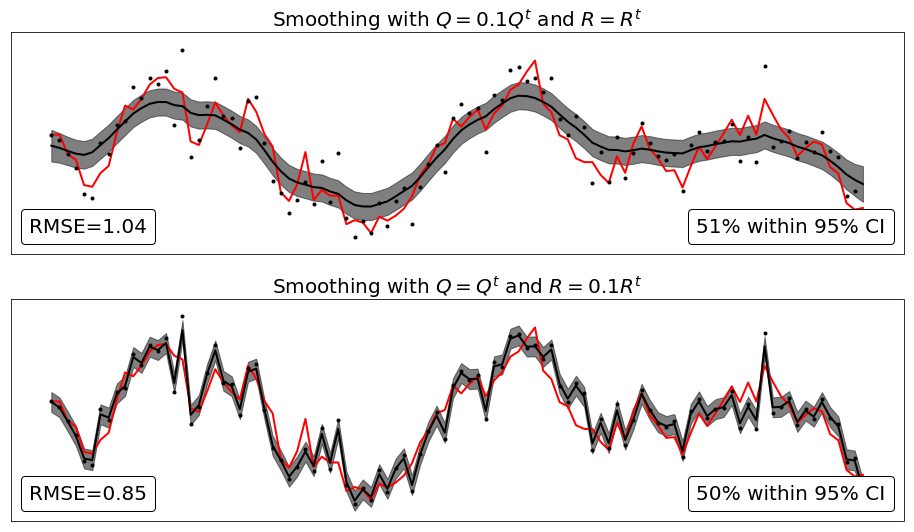

In [4]:
figure()
ax1=subplot(2,1,1);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_underest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_underest) - 1.96 * sqrt(squeeze(Ps_Q_underest)),
                        squeeze(Xs_Q_underest) + 1.96 * sqrt(squeeze(Ps_Q_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
#at=AnchoredText('a)',
#                prop=dict(size=20), frameon=False,
#                loc=2)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax1.add_artist(at)
at=AnchoredText('RMSE='+str(round(RMSE(ravel(Xs_Q_underest)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at=AnchoredText(str(int(nb_Q_underest*100))+'% within 95% CI',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
xticks([]);yticks([])
title('Smoothing with $Q=0.1Q^t$ and $R=R^t$', fontsize=20)

ax2=subplot(2,1,2);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_R_underest,'k',linewidth=2)
fill_between(range(T), squeeze(Xs_R_underest) - 1.96 * sqrt(squeeze(Ps_R_underest)),
                        squeeze(Xs_R_underest) + 1.96 * sqrt(squeeze(Ps_R_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
#at=AnchoredText('b)',
#                prop=dict(size=20), frameon=False,
#                loc=2)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax2.add_artist(at)
at=AnchoredText('RMSE='+str(round(RMSE(ravel(Xs_R_underest)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at=AnchoredText(str(int(nb_R_underest*100))+'% within 95% CI',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
xticks([]);yticks([])
title('Smoothing with $Q=Q^t$ and $R=0.1R^t$', fontsize=20)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp1_Q_R_AR1.png', bbox_inches='tight', pad_inches=0)

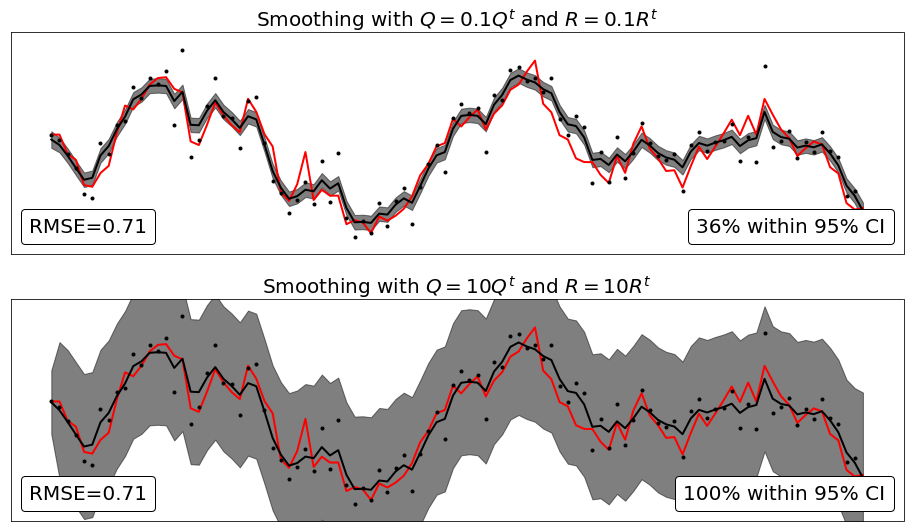

In [5]:
figure();
ax5=subplot(2,1,1);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_R_underest,'k',linewidth=2)
#line4,=plot(range(T),Xs_true_Q_R,'--g',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_R_underest) - 1.96 * sqrt(squeeze(Ps_Q_R_underest)),
                        squeeze(Xs_Q_R_underest) + 1.96 * sqrt(squeeze(Ps_Q_R_underest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
#at=AnchoredText('e)',
#                prop=dict(size=20), frameon=False,
#                loc=2)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax5.add_artist(at)
at=AnchoredText('RMSE='+str(round(RMSE(ravel(Xs_Q_R_underest)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
at=AnchoredText(str(int(nb_Q_R_underest*100))+'% within 95% CI',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
xticks([]);yticks([])
title('Smoothing with $Q=0.1Q^t$ and $R=0.1R^t$', fontsize=20)

ax6=subplot(2,1,2);
line1,=plot(range(T),X_true,'r',linewidth=2)
line2,=plot(range(T),Yo,'.k')
line3,=plot(range(T),Xs_Q_R_overest,'k',linewidth=2)
#line4,=plot(range(T),Xs_true_Q_R,'--g',linewidth=2)
fill_between(range(T), squeeze(Xs_Q_R_overest) - 1.96 * sqrt(squeeze(Ps_Q_R_overest)),
                        squeeze(Xs_Q_R_overest) + 1.96 * sqrt(squeeze(Ps_Q_R_overest)), color='k', alpha=.5)
ylim(min(Yo)-1,max(Yo)+1)
#at=AnchoredText('f)',
#                prop=dict(size=20), frameon=False,
#                loc=2)
#at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#ax6.add_artist(at)
at=AnchoredText('RMSE='+str(round(RMSE(ravel(Xs_Q_R_overest)-X_true),2)),
                prop=dict(size=20), frameon=True,
                loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)
at=AnchoredText(str(int(nb_Q_R_overest*100))+'% within 95% CI',
                prop=dict(size=20), frameon=True,
                loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax6.add_artist(at)
xticks([]);yticks([])
title('Smoothing with $Q=10Q^t$ and $R=10R^t$', fontsize=20)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/exp2_Q_R_AR1.png', bbox_inches='tight', pad_inches=0)